In [13]:
import pandas as pd
import torch
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def set_seed(seed=None):
  """
  A function to set the random seed.
    param seed: the random seed, 0 by default
  """
  if seed is None:
    seed = random.randrange(100)
  print("Seed:", seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

# Setting the random seed for reproducibility.
set_seed(42)

Seed: 42


Doing data pre-processing.

In [14]:
dataframe = pd.read_csv('data/input_vectors.csv')
# The dimension of the input vector (last column is the label)
input_dim = len(dataframe.columns) - 1
# Normalizing the columns
x = dataframe.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataframe = pd.DataFrame(x_scaled)
dataframe.columns

RangeIndex(start=0, stop=75, step=1)

Split the data into `training` and `test` data.

In [15]:
train_dataframe, test_dataframe = train_test_split(dataframe, test_size=0.2)

Building the dataset.

In [16]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Features, e.g. element count and volume
        x = torch.tensor(self.data[index, :-1], dtype=torch.float32)
        # Label (true value), e.g. melting point
        y = torch.tensor(self.data[index, -1], dtype=torch.float32)
        return x, y

# We convert the Pandas DataFrame called 'dataframe' to a PyTorch Dataset
train_dataset = PandasDataset(train_dataframe)
test_dataset = PandasDataset(train_dataframe)

Visualizing the dataset.

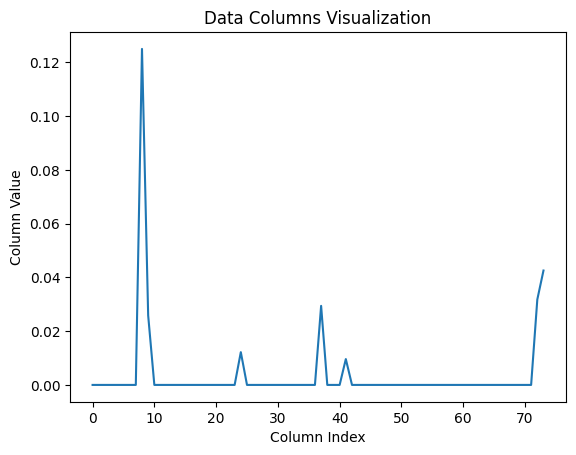

In [17]:
# Access the first sample from the dataset
sample_index = 1356
sample_x, sample_y = train_dataset[sample_index]

# Convert the PyTorch tensors to numpy arrays
sample_x = sample_x.numpy()
sample_y = sample_y.numpy()

# Plot the data columns
plt.figure()
plt.plot(sample_x)
plt.xlabel('Column Index')
plt.ylabel('Column Value')
plt.title('Data Columns Visualization')
plt.show()

Building the dataloader.

In [18]:
batch_size = 64

# Dataloaders for training and test data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Here we build the Neural Network.

In [19]:
import torch.nn as nn

class LinearNetwork(nn.Module):
  """
  A linear neural network.
  """
  def __init__(self, layer_sizes):
    self.output_dim = layer_sizes[-1]
    super(LinearNetwork, self).__init__()
    self.layer_1 = nn.Linear(layer_sizes[0], layer_sizes[1])
    self.layer_2 = nn.Linear(layer_sizes[1], layer_sizes[2])
    nn.init.kaiming_uniform_(self.layer_1.weight)
    nn.init.kaiming_uniform_(self.layer_2.weight)

  def forward(self, x):
    res1 = F.relu(self.layer_1(x))
    res = F.relu(self.layer_2(res1))
    res = F.relu(res)
    return res

In [20]:
# Initialize the network with correct layer size
my_network = LinearNetwork([input_dim, 36, 1])
# Optimizer for the Neural Network
optimizer = torch.optim.Adam(my_network.parameters(), lr=1e-4)

Define the loss function.

In [21]:
# Pytorch loss, e.g. Mean Squared Error.
loss_fn = nn.MSELoss()

def plot_loss(figname, train_loss=None, val_loss=None, title="Loss", smooth=0):
  """
  Plot the loss value over iterations.
    param figname: name of the figure
    param train_loss: list of train loss values
    param val_loss: list of validation loss values
    param title: title of the figure
  """
  plt.clf()
  # Plot and label the training and validation loss values
  if train_loss != None:
    ticks = np.arange(0, len(train_loss), 1)
    #plt.yscale('log')
    plt.plot(ticks, train_loss, label='Training Loss')
  if val_loss != None:
    ticks = np.arange(0, len(val_loss), 1)
    #plt.yscale('log')
    plt.plot(ticks, val_loss, label='Validation Loss')
  # Add in a title and axes labels
  plt.xlabel('Iteration')
  plt.ylabel('Loss value')
  plt.title(title)
  # Save the plot
  plt.legend(loc='best')
  plt.savefig(figname+".png")

Here we train our Neural Network.

In [22]:
def train_one_epoch(epoch_index=0):
    losses = []
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for data in train_dataloader:
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        prediction = my_network(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(prediction, labels)
        print('prediction {} label {}'.format(prediction[0].item(), labels[0].item()))
        loss.backward()

        # Adjust Neural Network's weights
        optimizer.step()

        # Gather data and report
        losses.append(loss.item())
        print('epoch {} loss: {}'.format(epoch_index, losses[-1]))

    return losses

In [23]:
train_losses = train_one_epoch()

prediction 0.0 label 0.1391492635011673
epoch 0 loss: 0.009676171466708183
prediction 0.04621195048093796 label 0.10165626555681229
epoch 0 loss: 0.009137098677456379
prediction 0.04460739344358444 label 0.1356705278158188
epoch 0 loss: 0.008188038133084774
prediction 0.07599124312400818 label 0.18669192492961884
epoch 0 loss: 0.02460181526839733
prediction 0.03141257166862488 label 0.11054635047912598
epoch 0 loss: 0.00952167995274067
prediction 0.05018197000026703 label 0.1369074136018753
epoch 0 loss: 0.00780585827305913
prediction 0.05954001843929291 label 0.1513248234987259
epoch 0 loss: 0.009426463395357132
prediction 0.048245176672935486 label 0.11247898638248444
epoch 0 loss: 0.008526628836989403
prediction 0.036340683698654175 label 0.12523433566093445
epoch 0 loss: 0.007964673452079296
prediction 0.04787243902683258 label 0.14146840572357178
epoch 0 loss: 0.008538080379366875
prediction 0.05488535761833191 label 0.1515180766582489
epoch 0 loss: 0.0088016577064991
prediction 0

/home/ipetruli/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ipetruli/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [24]:
plot_loss("loss_figure", train_losses, smooth=5)

NameError: name 'losses' is not defined

Now we evaluate the network.

In [ ]:
# We put the Neural Network to evaluation mode.
my_network.eval()

test_losses = []
# We look at test data accuraccy.
for i, data in enumerate(test_dataloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    # Make predictions for this batch
    prediction = my_network(inputs)
    # Compute the loss and its gradients
    loss = loss_fn(prediction, labels)
    # Gather data and report
    test_losses.append(loss.item())

# Print the average test loss
print("Avegare test loss:", sum(test_losses) / len(test_losses))
# Print the average training loss
print("Avegare train loss:", sum(train_losses) / len(train_losses))